Universidad de Buenos Aires

Trabajo Práctico Final - Computer Vision II

Alumnos:
- Leandro Royo
- Hans Burkil

Preprocesamiento y carga de datos:

In [1]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Configurar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imprimir el dispositivo
print(f"El dispositivo utilizado es: {device}")

El dispositivo utilizado es: cuda


In [3]:

# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño de entrada para redes preentrenadas
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Cargar el dataset desde los directorios
train_dir = './breast_cancer/train'
valid_dir = './breast_cancer/valid'
test_dir = './breast_cancer/test'

# Utilizar ImageFolder para cargar las imágenes desde los directorios
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Ver el balance de Clases:

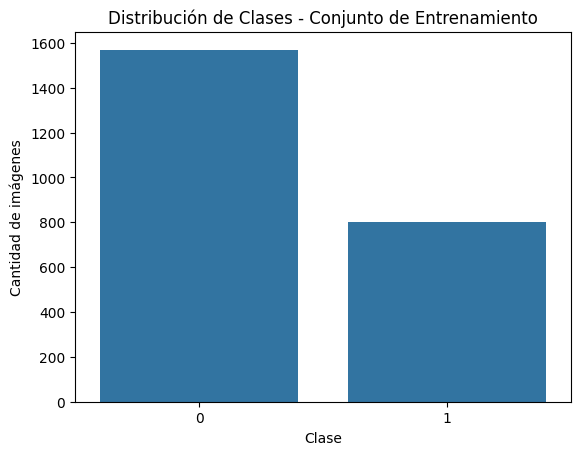

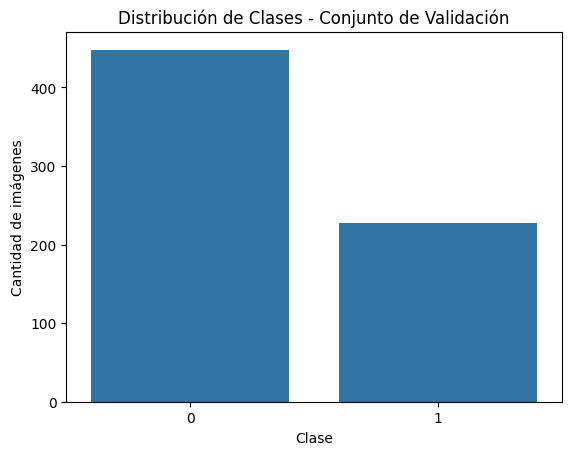

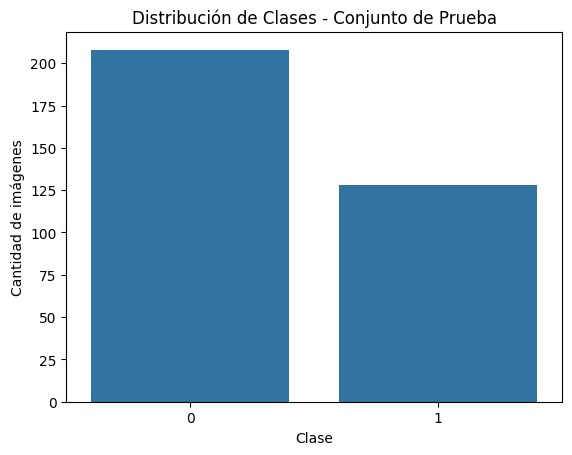

In [5]:

# Graficar la distribución de clases
def plot_class_distribution(dataset, title):
    count_classes = [0] * len(dataset.classes)
    for _, label in dataset:
        count_classes[label] += 1
    sns.barplot(x=dataset.classes, y=count_classes)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Cantidad de imágenes')
    plt.show()

plot_class_distribution(train_dataset, 'Distribución de Clases - Conjunto de Entrenamiento')
plot_class_distribution(valid_dataset, 'Distribución de Clases - Conjunto de Validación')
plot_class_distribution(test_dataset, 'Distribución de Clases - Conjunto de Prueba')


imágenes de la carpeta: breast_cancer\train/0


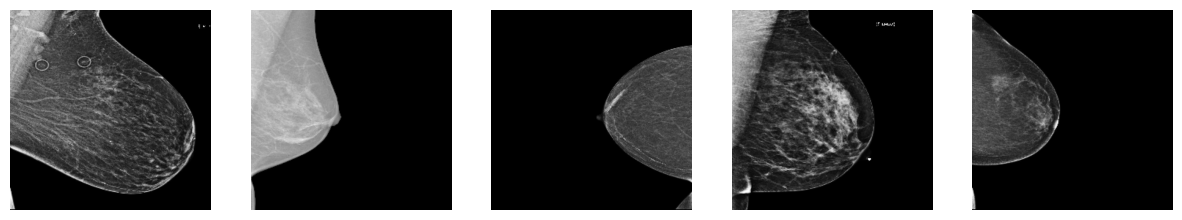

imágenes de la carpeta: breast_cancer\train/1


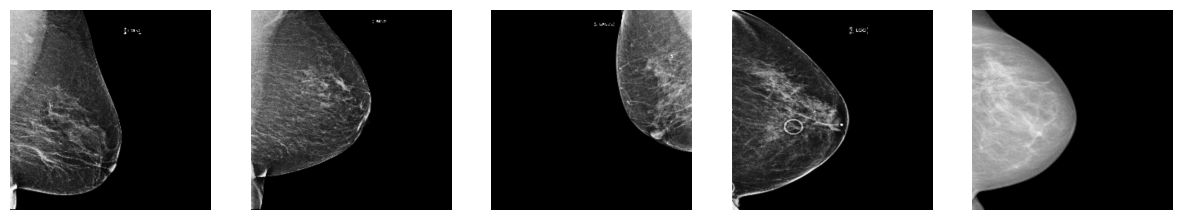

imágenes de la carpeta: breast_cancer\valid/0


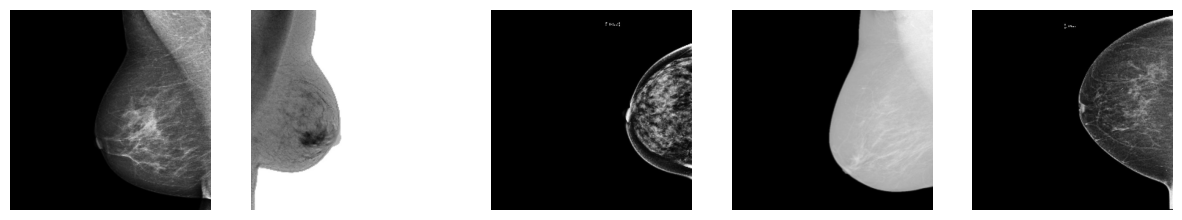

imágenes de la carpeta: breast_cancer\valid/1


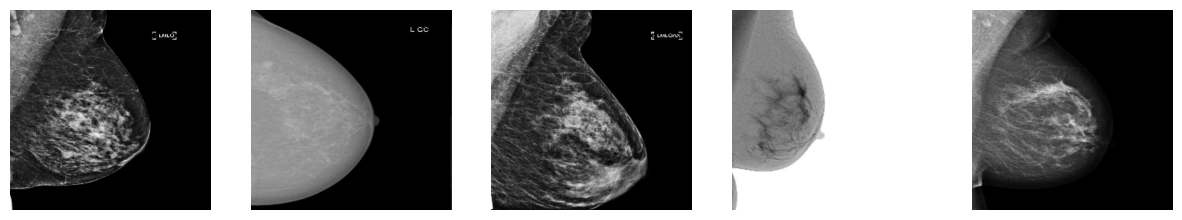

imágenes de la carpeta: breast_cancer\test/0


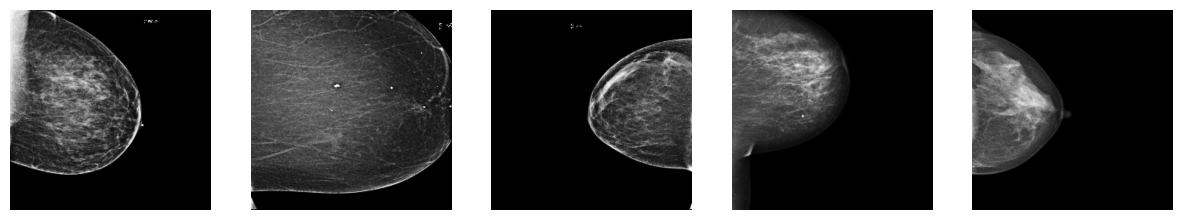

imágenes de la carpeta: breast_cancer\test/1


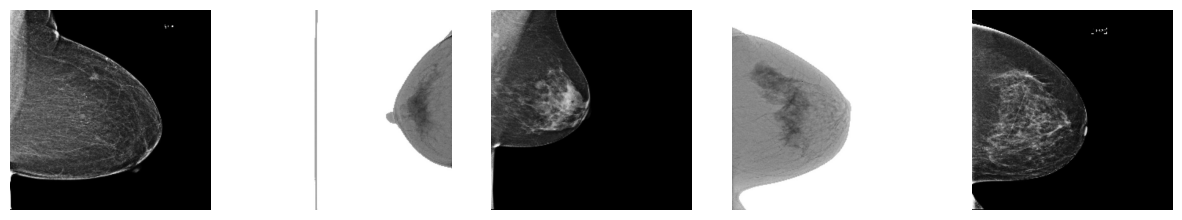

In [16]:
import random
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

# Función para mostrar imágenes de una carpeta específica
def show_images_from_folder(folder_path, num_images=5):
    # Obtener todas las imágenes de la carpeta
    images = os.listdir(folder_path)
    
    # Seleccionar aleatoriamente un subconjunto de imágenes
    selected_images = random.sample(images, min(num_images, len(images)))
    
    # Mostrar las imágenes
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 15))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = read_image(img_path)  # Leer la imagen
        img = ToPILImage()(img)  # Convertir a formato PIL para mostrar
        axes[i].imshow(img)
        #axes[i].set_title(img_name)
        axes[i].axis('off')
    plt.show()

# Paths a las carpetas del dataset
base_dir = 'breast_cancer'  # Asegúrate de ajustar esto al path correcto
folders = ['train/0', 'train/1', 'valid/0', 'valid/1', 'test/0', 'test/1']

# Mostrar imágenes de cada clase y cada conjunto de datos
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    print(f'imágenes de la carpeta: {folder_path}')
    show_images_from_folder(folder_path)


In [4]:
# Entrenamiento y evaluación
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Imprimir el resultado de la epoch
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
def train_and_evaluate_inception(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses, val_losses, accuracies, val_accuracies_inception = [], [], [], []
    
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Manejo de salida para Inception V3 (logits)
            if isinstance(outputs, tuple):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        accuracy = 100. * correct / total
        accuracies.append(accuracy)

        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                # Manejo de salida para Inception V3 (logits)
                if isinstance(outputs, tuple):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy_inception = 100. * correct / total
        val_accuracies_inception.append(val_accuracy_inception)

        # Impresión de métricas
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.2f}%, Val Accuracy: {val_accuracy_inception:.2f}%')

    return train_losses, val_losses, accuracies, val_accuracies_inception


In [7]:
epochs = 15
num_classes = 2

Entrenar y evaluar ResNet18:

In [8]:
# Cargar y configurar ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)  # Cambia 2 según el número de clases
model_resnet = model_resnet.to(device)

# Definir loss y optimizer para ResNet18
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-4)

In [20]:

# Entrenar y evaluar ResNet18
train_losses_resnet, val_losses_resnet, accuracies_resnet, val_accuracies_resnet = train_and_evaluate(
    model_resnet, train_loader, valid_loader, criterion_resnet, optimizer_resnet, epochs=epochs
)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 0.6504, Val Loss: 0.6118, Train Accuracy: 66.19%, Val Accuracy: 69.19%
Epoch 2/15, Train Loss: 0.4932, Val Loss: 0.6424, Train Accuracy: 76.18%, Val Accuracy: 68.30%
Epoch 3/15, Train Loss: 0.3254, Val Loss: 0.6978, Train Accuracy: 86.21%, Val Accuracy: 69.33%
Epoch 4/15, Train Loss: 0.2138, Val Loss: 0.9146, Train Accuracy: 92.12%, Val Accuracy: 65.93%
Epoch 5/15, Train Loss: 0.1654, Val Loss: 1.0038, Train Accuracy: 93.93%, Val Accuracy: 64.30%
Epoch 6/15, Train Loss: 0.1478, Val Loss: 0.9850, Train Accuracy: 95.36%, Val Accuracy: 66.37%
Epoch 7/15, Train Loss: 0.1168, Val Loss: 1.0308, Train Accuracy: 96.29%, Val Accuracy: 68.59%
Epoch 8/15, Train Loss: 0.1048, Val Loss: 1.0487, Train Accuracy: 96.75%, Val Accuracy: 69.19%
Epoch 9/15, Train Loss: 0.0632, Val Loss: 1.0680, Train Accuracy: 98.36%, Val Accuracy: 69.78%
Epoch 10/15, Train Loss: 0.0325, Val Loss: 1.0955, Train Accuracy: 99.07%, Val Accuracy: 69.33%
Epoch 11/15, Train Loss: 0.0123, Val Loss: 1.0854

Entrenar y evaluar Vgg16:

In [9]:
# Cargar y configurar VGG16
model_vgg = models.vgg16(pretrained=True)
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)
model_vgg = model_vgg.to(device)

# Definir loss y optimizer para VGG16
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=1e-4)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:

# Entrenar y evaluar VGG16
train_losses_vgg, val_losses_vgg, accuracies_vgg, val_accuracies_vgg = train_and_evaluate(
    model_vgg, train_loader, valid_loader, criterion_vgg, optimizer_vgg, epochs=epochs
)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 0.6401, Val Loss: 0.6406, Train Accuracy: 64.92%, Val Accuracy: 58.07%
Epoch 2/15, Train Loss: 0.6261, Val Loss: 0.6231, Train Accuracy: 66.32%, Val Accuracy: 67.11%
Epoch 3/15, Train Loss: 0.6269, Val Loss: 0.6512, Train Accuracy: 66.27%, Val Accuracy: 66.37%
Epoch 4/15, Train Loss: 0.6109, Val Loss: 0.6180, Train Accuracy: 66.82%, Val Accuracy: 65.48%
Epoch 5/15, Train Loss: 0.6052, Val Loss: 0.6164, Train Accuracy: 67.66%, Val Accuracy: 66.37%
Epoch 6/15, Train Loss: 0.5799, Val Loss: 0.6088, Train Accuracy: 69.22%, Val Accuracy: 65.78%
Epoch 7/15, Train Loss: 0.5642, Val Loss: 0.6141, Train Accuracy: 69.81%, Val Accuracy: 67.11%
Epoch 8/15, Train Loss: 0.5475, Val Loss: 0.5848, Train Accuracy: 72.13%, Val Accuracy: 68.44%
Epoch 9/15, Train Loss: 0.4973, Val Loss: 0.6677, Train Accuracy: 75.38%, Val Accuracy: 69.19%
Epoch 10/15, Train Loss: 0.4462, Val Loss: 0.6185, Train Accuracy: 78.29%, Val Accuracy: 68.15%
Epoch 11/15, Train Loss: 0.3962, Val Loss: 0.6457

Entrenar y evaluar inception V3:

In [37]:

# Transforms específicos para Inception V3
inception_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Cambiar tamaño de la imagen a 299x299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización estándar
])

# Dataset y DataLoader para Inception V3
train_dataset_inception = datasets.ImageFolder(root=train_dir, transform=inception_transforms)
valid_dataset_inception = datasets.ImageFolder(root=valid_dir, transform=inception_transforms)

train_loader_inception = torch.utils.data.DataLoader(train_dataset_inception, batch_size=32, shuffle=True)
valid_loader_inception = torch.utils.data.DataLoader(valid_dataset_inception, batch_size=32, shuffle=False)


In [12]:
# Cargar y configurar Inception V3
model_inception = models.inception_v3(pretrained=True)
model_inception = models.inception_v3(pretrained=False, num_classes=num_classes, aux_logits=True)

model_inception.fc = nn.Linear(model_inception.fc.in_features, num_classes)  # Cambia 2 según el número de clases
model_inception = model_inception.to(device)

# Definir loss y optimizer para Inception V3
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(model_inception.parameters(), lr=1e-4)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\leand\anaconda3\envs

In [39]:
# Entrenar y evaluar Inception V3
train_losses_inception, val_losses_inception, accuracies_inception, val_accuracies_inception = train_and_evaluate_inception(
    model_inception, train_loader_inception, valid_loader_inception, criterion_inception, optimizer_inception, epochs=epochs
)

Epoch 1/15, Train Loss: 0.6500, Val Loss: 0.6396, Train Accuracy: 65.56%, Val Accuracy: 66.52%
Epoch 2/15, Train Loss: 0.6341, Val Loss: 0.6219, Train Accuracy: 65.26%, Val Accuracy: 66.37%
Epoch 3/15, Train Loss: 0.6230, Val Loss: 0.6437, Train Accuracy: 65.35%, Val Accuracy: 62.81%
Epoch 4/15, Train Loss: 0.6211, Val Loss: 0.6415, Train Accuracy: 66.06%, Val Accuracy: 66.37%
Epoch 5/15, Train Loss: 0.6147, Val Loss: 0.6318, Train Accuracy: 65.94%, Val Accuracy: 66.96%
Epoch 6/15, Train Loss: 0.6121, Val Loss: 0.6051, Train Accuracy: 67.75%, Val Accuracy: 68.00%
Epoch 7/15, Train Loss: 0.5975, Val Loss: 0.6102, Train Accuracy: 67.92%, Val Accuracy: 66.81%
Epoch 8/15, Train Loss: 0.5948, Val Loss: 0.6534, Train Accuracy: 68.76%, Val Accuracy: 67.41%
Epoch 9/15, Train Loss: 0.5919, Val Loss: 0.6709, Train Accuracy: 69.22%, Val Accuracy: 66.81%
Epoch 10/15, Train Loss: 0.5745, Val Loss: 0.6331, Train Accuracy: 69.98%, Val Accuracy: 65.33%
Epoch 11/15, Train Loss: 0.5689, Val Loss: 0.6171

Graficar resultados:

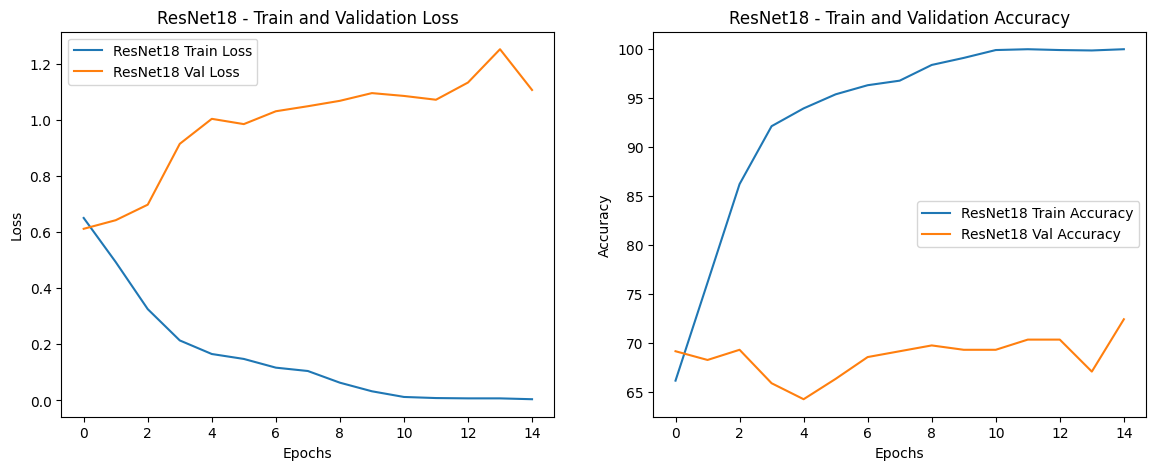

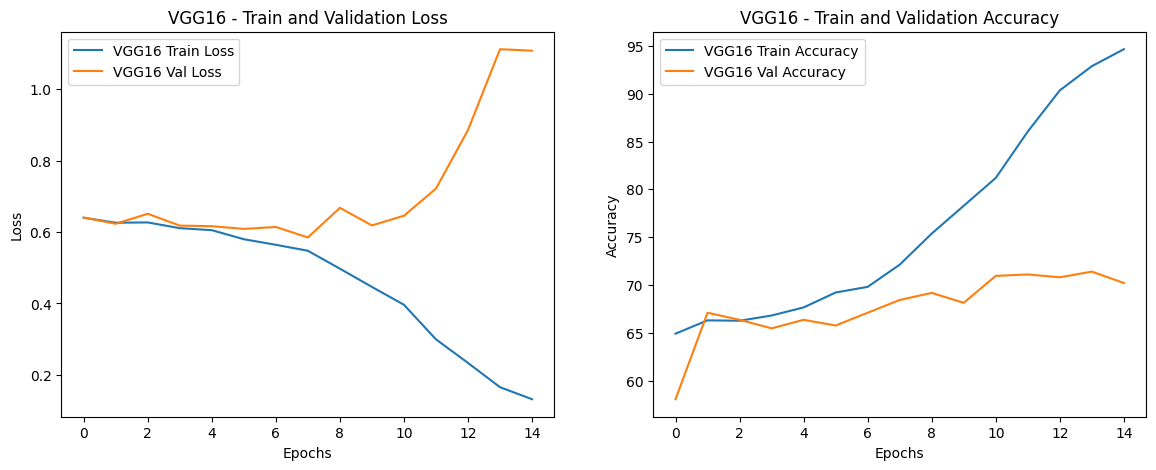

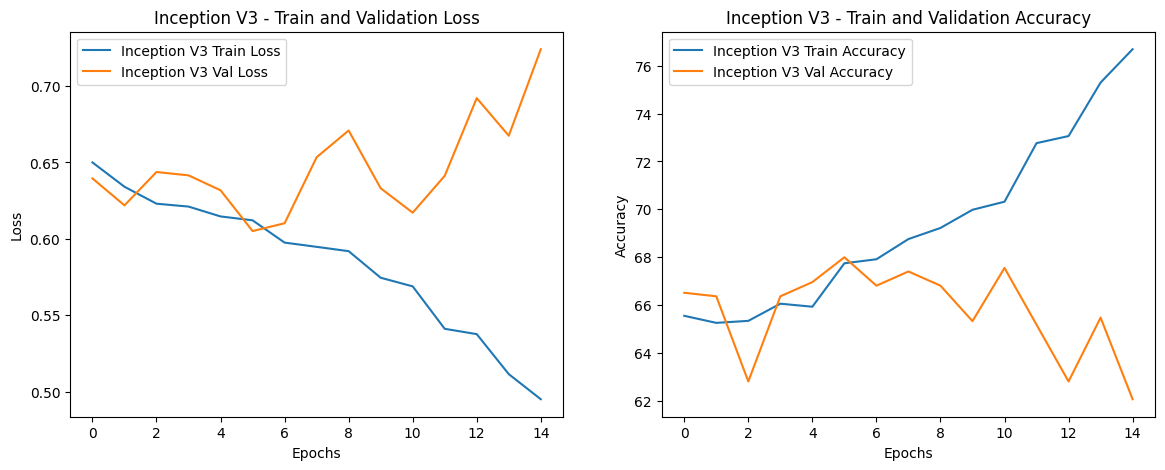

In [40]:
# Graficar métricas para ResNet18, VGG16, e Inception V3
def plot_metrics_individual(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    plt.figure(figsize=(14, 5))

    # Gráfico de pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'{model_name} Train Loss')
    plt.plot(val_losses, label=f'{model_name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Train and Validation Loss')

    # Gráfico de accuracy (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'{model_name} Train Accuracy')
    plt.plot(val_accuracies, label=f'{model_name} Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Train and Validation Accuracy')

    plt.show()

# Graficar para ResNet18
plot_metrics_individual(train_losses_resnet, val_losses_resnet, accuracies_resnet, val_accuracies_resnet, 'ResNet18')

# Graficar para VGG16
plot_metrics_individual(train_losses_vgg, val_losses_vgg, accuracies_vgg, val_accuracies_vgg, 'VGG16')

# Graficar para Inception V3
plot_metrics_individual(train_losses_inception, val_losses_inception, accuracies_inception, val_accuracies_inception, 'Inception V3')



Todos los modelos muestran signos de sobreajuste a partir de cierto punto, lo que indica que están memorizando el ruido de los datos de entrenamiento en lugar de aprender las características generales.

Procedemos a realizar data augmentation para darle más variabilidad a los datos y que el modelo no se sobreajuste a los datos de entrenamiento

In [10]:
# Definir las transformaciones para el conjunto de entrenamiento (con augmentations)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Recorta y cambia el tamaño aleatoriamente
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
    transforms.RandomRotation(10),  # Rotación aleatoria hasta 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios de color
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización según ImageNet
])

# Transformaciones para el conjunto de validación (sin augmentations)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar los datasets
train_dataset = datasets.ImageFolder(root='breast_cancer/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='breast_cancer/valid', transform=val_transforms)

# Cargar los datasets en DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)


Ahora se procederá a entrenar nuevamente los modelos:

Resnet con Data Augmentation:

In [42]:
# Entrenar y evaluar el modelo con data augmentation
train_losses_resnet, val_losses_resnet, accuracies_resnet, val_accuracies_resnet = train_and_evaluate(
    model_resnet, train_loader, valid_loader, criterion_resnet, optimizer_resnet, epochs=epochs
)


Epoch 1/15, Train Loss: 0.8387, Val Loss: 0.6430, Train Accuracy: 62.48%, Val Accuracy: 66.52%
Epoch 2/15, Train Loss: 0.6255, Val Loss: 0.6186, Train Accuracy: 66.27%, Val Accuracy: 67.56%
Epoch 3/15, Train Loss: 0.6249, Val Loss: 0.6127, Train Accuracy: 65.77%, Val Accuracy: 68.00%
Epoch 4/15, Train Loss: 0.6239, Val Loss: 0.6090, Train Accuracy: 66.53%, Val Accuracy: 69.04%
Epoch 5/15, Train Loss: 0.6154, Val Loss: 0.6102, Train Accuracy: 66.40%, Val Accuracy: 68.00%
Epoch 6/15, Train Loss: 0.6057, Val Loss: 0.6152, Train Accuracy: 68.59%, Val Accuracy: 69.48%
Epoch 7/15, Train Loss: 0.6071, Val Loss: 0.6060, Train Accuracy: 67.33%, Val Accuracy: 68.44%
Epoch 8/15, Train Loss: 0.5936, Val Loss: 0.5808, Train Accuracy: 69.06%, Val Accuracy: 69.19%
Epoch 9/15, Train Loss: 0.5906, Val Loss: 0.5752, Train Accuracy: 69.27%, Val Accuracy: 69.78%
Epoch 10/15, Train Loss: 0.5772, Val Loss: 0.5740, Train Accuracy: 69.77%, Val Accuracy: 69.33%
Epoch 11/15, Train Loss: 0.5718, Val Loss: 0.5752

VGG con Data Augmentation:

In [43]:
# Entrenar y evaluar VGG16
train_losses_vgg, val_losses_vgg, accuracies_vgg, val_accuracies_vgg = train_and_evaluate(
    model_vgg, train_loader, valid_loader, criterion_vgg, optimizer_vgg, epochs=epochs
)


Epoch 1/15, Train Loss: 0.6710, Val Loss: 0.6528, Train Accuracy: 65.89%, Val Accuracy: 66.52%
Epoch 2/15, Train Loss: 0.6414, Val Loss: 0.6501, Train Accuracy: 66.32%, Val Accuracy: 66.67%
Epoch 3/15, Train Loss: 0.6313, Val Loss: 0.6081, Train Accuracy: 66.95%, Val Accuracy: 69.48%
Epoch 4/15, Train Loss: 0.6247, Val Loss: 0.5982, Train Accuracy: 66.91%, Val Accuracy: 69.19%
Epoch 5/15, Train Loss: 0.6242, Val Loss: 0.6062, Train Accuracy: 67.45%, Val Accuracy: 69.48%
Epoch 6/15, Train Loss: 0.6140, Val Loss: 0.5925, Train Accuracy: 67.28%, Val Accuracy: 68.44%
Epoch 7/15, Train Loss: 0.6160, Val Loss: 0.5986, Train Accuracy: 67.88%, Val Accuracy: 68.74%
Epoch 8/15, Train Loss: 0.6124, Val Loss: 0.5868, Train Accuracy: 68.04%, Val Accuracy: 68.44%
Epoch 9/15, Train Loss: 0.6016, Val Loss: 0.5921, Train Accuracy: 68.21%, Val Accuracy: 68.59%
Epoch 10/15, Train Loss: 0.6180, Val Loss: 0.6005, Train Accuracy: 67.62%, Val Accuracy: 68.89%
Epoch 11/15, Train Loss: 0.6130, Val Loss: 0.5913

Inception con Data Augmentation:

In [10]:
# Definir las transformaciones para el conjunto de entrenamiento (con augmentations para Inception V3)
train_transforms_inception = transforms.Compose([
    transforms.Resize(299),  # Redimensionar las imágenes a 299x299
    transforms.RandomResizedCrop(299),  # Recortar y cambiar el tamaño aleatoriamente a 299x299
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
    transforms.RandomRotation(10),  # Rotación aleatoria hasta 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios de color
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización según ImageNet
])

# Transformaciones para el conjunto de validación (sin augmentations para Inception V3)
val_transforms_inception = transforms.Compose([
    transforms.Resize(299),  # Redimensionar a 299x299
    transforms.CenterCrop(299),  # Recortar el centro de la imagen
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización según ImageNet
])

# Cargar los datasets con las nuevas transformaciones para Inception V3
train_dataset_inception = datasets.ImageFolder(root='breast_cancer/train', transform=train_transforms_inception)
valid_dataset_inception = datasets.ImageFolder(root='breast_cancer/valid', transform=val_transforms_inception)

# Cargar los datasets en DataLoaders
train_loader_inception = torch.utils.data.DataLoader(train_dataset_inception, batch_size=32, shuffle=True)
valid_loader_inception = torch.utils.data.DataLoader(valid_dataset_inception, batch_size=32, shuffle=False)


In [45]:
# Entrenar y evaluar Inception V3
train_losses_inception, val_losses_inception, accuracies_inception, val_accuracies_inception = train_and_evaluate_inception(
    model_inception, train_loader_inception, valid_loader_inception, criterion_inception, optimizer_inception, epochs=epochs
)

Epoch 1/15, Train Loss: 0.6787, Val Loss: 0.6794, Train Accuracy: 63.83%, Val Accuracy: 58.96%
Epoch 2/15, Train Loss: 0.6425, Val Loss: 0.6393, Train Accuracy: 65.81%, Val Accuracy: 65.48%
Epoch 3/15, Train Loss: 0.6447, Val Loss: 0.6269, Train Accuracy: 65.18%, Val Accuracy: 66.96%
Epoch 4/15, Train Loss: 0.6341, Val Loss: 0.6358, Train Accuracy: 65.35%, Val Accuracy: 62.67%
Epoch 5/15, Train Loss: 0.6439, Val Loss: 0.6925, Train Accuracy: 65.26%, Val Accuracy: 65.63%
Epoch 6/15, Train Loss: 0.6411, Val Loss: 0.6153, Train Accuracy: 64.76%, Val Accuracy: 65.19%
Epoch 7/15, Train Loss: 0.6420, Val Loss: 0.6625, Train Accuracy: 66.23%, Val Accuracy: 65.19%
Epoch 8/15, Train Loss: 0.6375, Val Loss: 0.7538, Train Accuracy: 65.18%, Val Accuracy: 65.93%
Epoch 9/15, Train Loss: 0.6382, Val Loss: 0.6575, Train Accuracy: 65.39%, Val Accuracy: 65.93%
Epoch 10/15, Train Loss: 0.6381, Val Loss: 0.7209, Train Accuracy: 66.23%, Val Accuracy: 57.04%
Epoch 11/15, Train Loss: 0.6239, Val Loss: 0.6200

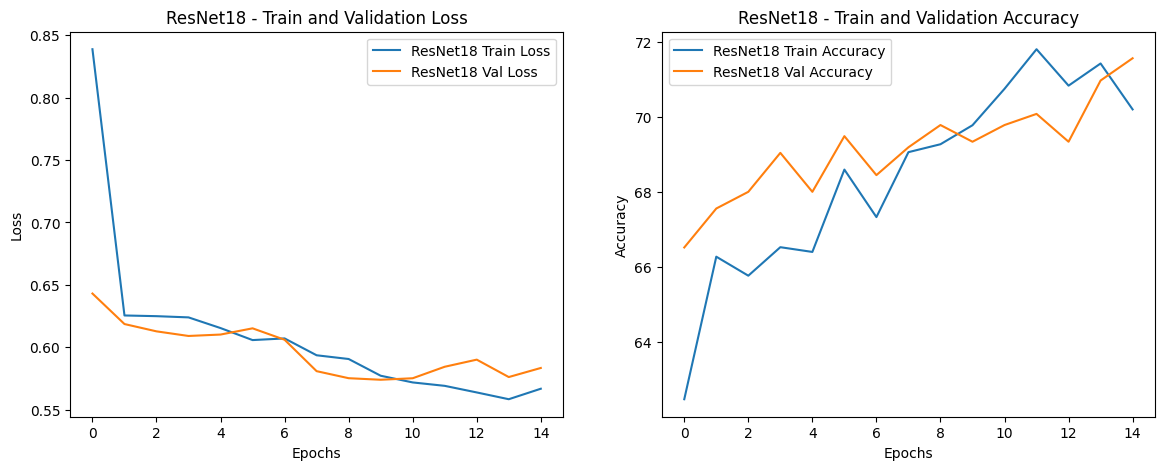

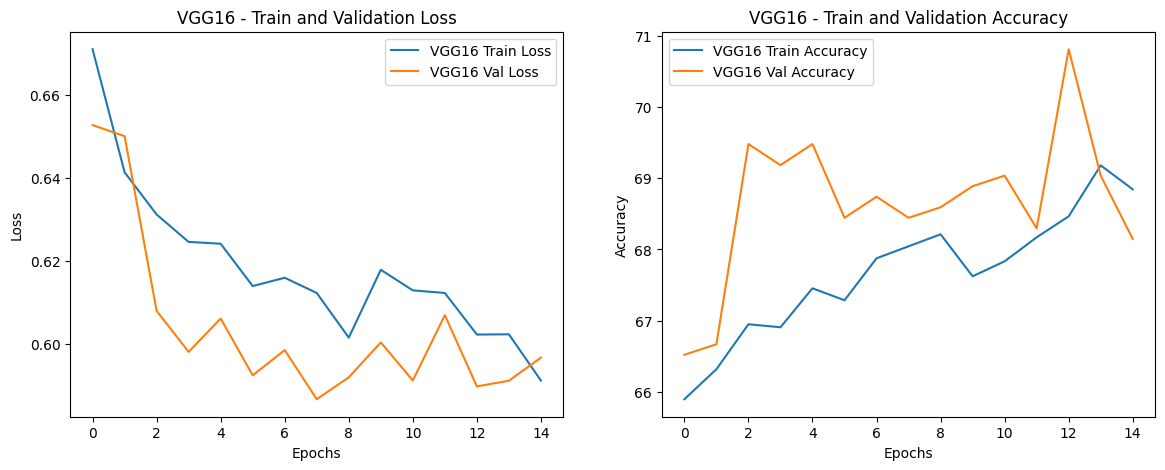

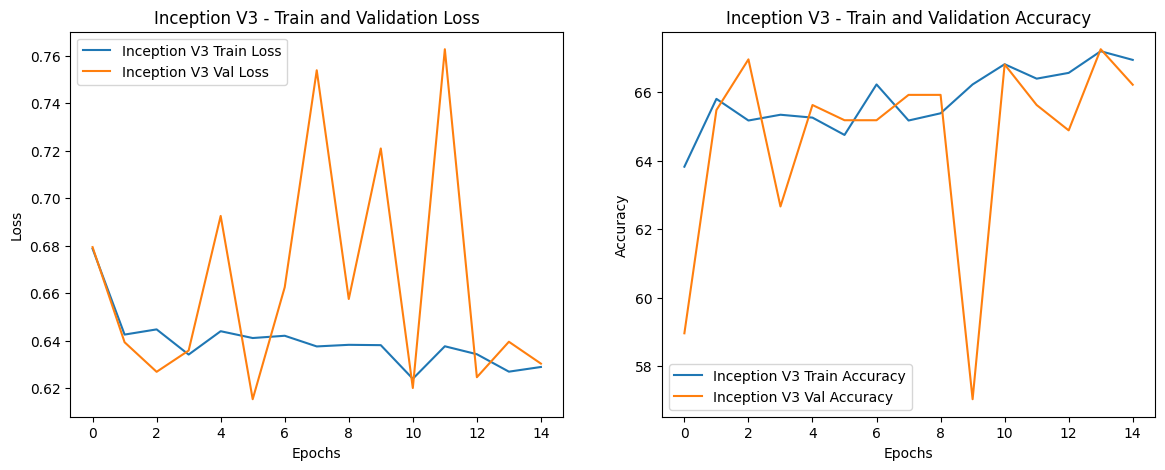

In [46]:
# Graficar métricas para ResNet18, VGG16, e Inception V3
def plot_metrics_individual(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    plt.figure(figsize=(14, 5))

    # Gráfico de pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'{model_name} Train Loss')
    plt.plot(val_losses, label=f'{model_name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Train and Validation Loss')

    # Gráfico de accuracy (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'{model_name} Train Accuracy')
    plt.plot(val_accuracies, label=f'{model_name} Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Train and Validation Accuracy')

    plt.show()

# Graficar para ResNet18
plot_metrics_individual(train_losses_resnet, val_losses_resnet, accuracies_resnet, val_accuracies_resnet, 'ResNet18')

# Graficar para VGG16
plot_metrics_individual(train_losses_vgg, val_losses_vgg, accuracies_vgg, val_accuracies_vgg, 'VGG16')

# Graficar para Inception V3
plot_metrics_individual(train_losses_inception, val_losses_inception, accuracies_inception, val_accuracies_inception, 'Inception V3')


Vemos variaciones importantes en el último caso, vamos a probar entrenando los dos primeros modelos por más épocas para ver cuál es el comportamiento:

In [11]:
epochs = 60

Resnet entrenada durante más épocas:

In [12]:
# Entrenar y evaluar el modelo con data augmentation
train_losses_resnet, val_losses_resnet, accuracies_resnet, val_accuracies_resnet = train_and_evaluate(
    model_resnet, train_loader, valid_loader, criterion_resnet, optimizer_resnet, epochs=epochs
)


Epoch 1/60, Train Loss: 0.6635, Val Loss: 0.6093, Train Accuracy: 64.29%, Val Accuracy: 65.33%
Epoch 2/60, Train Loss: 0.6434, Val Loss: 0.6395, Train Accuracy: 65.30%, Val Accuracy: 67.11%
Epoch 3/60, Train Loss: 0.6426, Val Loss: 0.6235, Train Accuracy: 65.81%, Val Accuracy: 67.56%
Epoch 4/60, Train Loss: 0.6321, Val Loss: 0.6652, Train Accuracy: 65.60%, Val Accuracy: 67.11%
Epoch 5/60, Train Loss: 0.6266, Val Loss: 0.6499, Train Accuracy: 65.68%, Val Accuracy: 67.70%
Epoch 6/60, Train Loss: 0.6156, Val Loss: 0.6501, Train Accuracy: 66.78%, Val Accuracy: 59.26%
Epoch 7/60, Train Loss: 0.6080, Val Loss: 0.5931, Train Accuracy: 68.80%, Val Accuracy: 68.44%
Epoch 8/60, Train Loss: 0.5976, Val Loss: 0.5987, Train Accuracy: 67.88%, Val Accuracy: 66.81%
Epoch 9/60, Train Loss: 0.5955, Val Loss: 0.6292, Train Accuracy: 68.51%, Val Accuracy: 68.15%
Epoch 10/60, Train Loss: 0.5894, Val Loss: 0.5978, Train Accuracy: 68.63%, Val Accuracy: 66.96%
Epoch 11/60, Train Loss: 0.5765, Val Loss: 0.6167

Ahora probamos con Resnet pero con una arquitectura con más profundidad, Resnet50:

In [14]:

# Cargar y configurar ResNet50
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)  # Ajustar la capa final para el número de clases
model_resnet50 = model_resnet50.to(device)

# Definir loss y optimizer para ResNet50
criterion_resnet50 = nn.CrossEntropyLoss()  # Puedes agregar weights para las clases si tienes desbalance
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=1e-4)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\leand/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [15]:
# Entrenar y evaluar ResNet50
train_losses_resnet50, val_losses_resnet50, accuracies_resnet50, val_accuracies_resnet50 = train_and_evaluate(
    model_resnet50, train_loader, valid_loader, criterion_resnet50, optimizer_resnet50, epochs=epochs
)

Epoch 1/60, Train Loss: 0.6555, Val Loss: 0.6930, Train Accuracy: 63.66%, Val Accuracy: 57.63%
Epoch 2/60, Train Loss: 0.6439, Val Loss: 0.6582, Train Accuracy: 64.92%, Val Accuracy: 55.56%
Epoch 3/60, Train Loss: 0.6365, Val Loss: 0.6083, Train Accuracy: 64.59%, Val Accuracy: 65.33%
Epoch 4/60, Train Loss: 0.6267, Val Loss: 0.6156, Train Accuracy: 65.56%, Val Accuracy: 63.26%
Epoch 5/60, Train Loss: 0.6239, Val Loss: 0.6107, Train Accuracy: 66.91%, Val Accuracy: 69.04%
Epoch 6/60, Train Loss: 0.6083, Val Loss: 0.5895, Train Accuracy: 67.33%, Val Accuracy: 67.41%
Epoch 7/60, Train Loss: 0.5917, Val Loss: 0.5912, Train Accuracy: 69.52%, Val Accuracy: 69.33%
Epoch 8/60, Train Loss: 0.5997, Val Loss: 0.6228, Train Accuracy: 68.25%, Val Accuracy: 68.00%
Epoch 9/60, Train Loss: 0.5837, Val Loss: 0.6054, Train Accuracy: 69.31%, Val Accuracy: 68.00%
Epoch 10/60, Train Loss: 0.5896, Val Loss: 0.5878, Train Accuracy: 69.65%, Val Accuracy: 68.74%
Epoch 11/60, Train Loss: 0.5832, Val Loss: 0.5826

Normalizando para que el peso menor sea 1:
Clase 0: 0.833 / 0.833 = 1
Clase 1: 1.25 / 0.833 ≈ 1.5

Ahora probamos con el modelo de DenseNet121:

In [17]:
# Cargar y configurar DenseNet
model_densenet = models.densenet121(pretrained=True)  # Puedes cambiar el modelo a otros de la familia DenseNet
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, num_classes)  # Ajuste de salida
model_densenet = model_densenet.to(device)

# Definir loss y optimizer para DenseNet
class_weights = torch.tensor([1.0, 1.5]).to(device)  # Ajuste de pesos según el desbalance de clases
criterion_densenet = nn.CrossEntropyLoss(weight=class_weights)
optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=1e-4)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

# Entrenar y evaluar DenseNet
train_losses_densenet, val_losses_densenet, accuracies_densenet, val_accuracies_densenet = train_and_evaluate(
    model_densenet, train_loader, valid_loader, criterion_densenet, optimizer_densenet, epochs=20
)

Epoch 1/20, Train Loss: 0.7002, Val Loss: 0.6500, Train Accuracy: 58.18%, Val Accuracy: 68.59%
Epoch 2/20, Train Loss: 0.6810, Val Loss: 0.6262, Train Accuracy: 62.82%, Val Accuracy: 63.26%
Epoch 3/20, Train Loss: 0.6685, Val Loss: 0.6394, Train Accuracy: 62.48%, Val Accuracy: 64.44%
Epoch 4/20, Train Loss: 0.6554, Val Loss: 0.6516, Train Accuracy: 62.44%, Val Accuracy: 61.93%
Epoch 5/20, Train Loss: 0.6391, Val Loss: 0.6135, Train Accuracy: 65.68%, Val Accuracy: 61.78%
Epoch 6/20, Train Loss: 0.6315, Val Loss: 0.6713, Train Accuracy: 65.94%, Val Accuracy: 61.19%
Epoch 7/20, Train Loss: 0.6205, Val Loss: 0.5600, Train Accuracy: 67.50%, Val Accuracy: 69.48%
Epoch 8/20, Train Loss: 0.6424, Val Loss: 0.6908, Train Accuracy: 64.63%, Val Accuracy: 58.52%
Epoch 9/20, Train Loss: 0.6111, Val Loss: 0.5502, Train Accuracy: 69.35%, Val Accuracy: 69.48%
Epoch 10/20, Train Loss: 0.5974, Val Loss: 0.6276, Train Accuracy: 68.76%, Val Accuracy: 68.00%
Epoch 11/20, Train Loss: 0.6160, Val Loss: 0.6028

Con las técnicas aplicadas de feature extraction vemos que tenemos un límite respecto a las métricas y el sobreentrenamiento de las redes que se probaron.

Por este motivo procederemos a realizar las pruebas realizando fine tuning, es decir descongelando las últimas capas de la red para que se reentrenen para el propósito que se necesita.

En este caso realizaremos fine tuning sobre la red Resnet50 que es de las que mejor performance ha mostrado hasta el momento para la tarea:

In [19]:
# Cargar y configurar ResNet50
model_resnet50 = models.resnet50(pretrained=True)

# Congelar todas las capas
for param in model_resnet50.parameters():
    param.requires_grad = False

# Descongelar las últimas capas (por ejemplo, las capas 4 y el fully connected layer)
for param in model_resnet50.layer4.parameters():  # Descongelar la última capa convolucional
    param.requires_grad = True

# Reemplazar la capa fully connected para la nueva tarea
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)  
for param in model_resnet50.fc.parameters():  # Descongelar la capa fully connected
    param.requires_grad = True

# Mover el modelo a la GPU
model_resnet50 = model_resnet50.to(device)

# Definir el criterio y el optimizador
criterion_resnet50 = nn.CrossEntropyLoss(weight=torch.tensor([0.6, 0.4]).to(device))  # Ajuste por el desbalance de clases
optimizer_resnet50 = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=1e-4)


c:\Users\leand\anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Entrenar y evaluar ResNet50 con Fine-Tuning
train_losses_resnet50, val_losses_resnet50, accuracies_resnet50, val_accuracies_resnet50 = train_and_evaluate(
    model_resnet50, train_loader, valid_loader, criterion_resnet50, optimizer_resnet50, epochs=epochs
)

Epoch 1/60, Train Loss: 0.5784, Val Loss: 0.6279, Train Accuracy: 65.85%, Val Accuracy: 67.70%
Epoch 2/60, Train Loss: 0.5699, Val Loss: 0.6636, Train Accuracy: 66.53%, Val Accuracy: 67.11%
Epoch 3/60, Train Loss: 0.5586, Val Loss: 0.6683, Train Accuracy: 66.53%, Val Accuracy: 66.37%
Epoch 4/60, Train Loss: 0.5542, Val Loss: 0.6603, Train Accuracy: 66.61%, Val Accuracy: 67.41%
Epoch 5/60, Train Loss: 0.5434, Val Loss: 0.6385, Train Accuracy: 67.03%, Val Accuracy: 66.81%
Epoch 6/60, Train Loss: 0.5393, Val Loss: 0.6322, Train Accuracy: 67.66%, Val Accuracy: 66.07%
Epoch 7/60, Train Loss: 0.5346, Val Loss: 0.6518, Train Accuracy: 67.88%, Val Accuracy: 67.41%
Epoch 8/60, Train Loss: 0.5302, Val Loss: 0.6075, Train Accuracy: 68.59%, Val Accuracy: 66.67%
Epoch 9/60, Train Loss: 0.5394, Val Loss: 0.6202, Train Accuracy: 67.37%, Val Accuracy: 68.15%
Epoch 10/60, Train Loss: 0.5289, Val Loss: 0.6006, Train Accuracy: 68.25%, Val Accuracy: 68.00%
Epoch 11/60, Train Loss: 0.5161, Val Loss: 0.6226

Ahora procedemos a descongelar una capa más:

In [21]:
# Cargar y configurar ResNet50
model_resnet50 = models.resnet50(pretrained=True)

# Congelar todas las capas
for param in model_resnet50.parameters():
    param.requires_grad = False

    # Descongelar las capas 3
for param in model_resnet50.layer3.parameters():
    param.requires_grad = True

# Descongelar la capas 4
for param in model_resnet50.layer4.parameters():  # Descongelar la última capa convolucional
    param.requires_grad = True

# Reemplazar la capa fully connected para la nueva tarea
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)  
for param in model_resnet50.fc.parameters():  # Descongelar la capa fully connected
    param.requires_grad = True

# Mover el modelo a la GPU
model_resnet50 = model_resnet50.to(device)

# Definir el criterio y el optimizador
criterion_resnet50 = nn.CrossEntropyLoss(weight=torch.tensor([0.6, 0.4]).to(device))  # Ajuste por el desbalance de clases
optimizer_resnet50 = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=1e-4)


In [ ]:
epochs = 20

# Entrenar y evaluar ResNet50 con Fine-Tuning
train_losses_resnet50, val_losses_resnet50, accuracies_resnet50, val_accuracies_resnet50 = train_and_evaluate(
    model_resnet50, train_loader, valid_loader, criterion_resnet50, optimizer_resnet50, epochs=epochs
)